


# Transfer Learning
ResNet152 Transfer Learning, tuning all layers on 45k samples that yields 96% accuracy on test set.



## Imports

In [18]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [17]:
!nvidia-smi

Mon Mar 22 18:03:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    39W / 250W |  15563MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes.

In [3]:
import tensorflow_datasets as tfds

In [4]:
def normalize_and_onehot(features, labels):
    return tf.cast(features, tf.float32) / 255.0, tf.one_hot(labels,10)

In [5]:
train_ds, val_ds, test_ds = tfds.load('cifar10', split=['train[:90%]', 'train[90%:]', 'test'],
                             as_supervised=True)
autotune = tf.data.experimental.AUTOTUNE

train_ds = train_ds.batch(64).map(normalize_and_onehot).prefetch(autotune).shuffle(1024)
val_ds = val_ds.batch(64).map(normalize_and_onehot).prefetch(autotune).shuffle(1024)
test_ds = test_ds.batch(64).map(normalize_and_onehot).prefetch(autotune).shuffle(1024)

In [7]:
train_ds

<ShuffleDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>

## Define the Network
Let's use ResNet152 gigantic model for this task. Training will be done a dataset which has 45k samples since we loaded 90% for training, 5k samples for validation.

* To prevent overfitting, experimental layers were used.

In [6]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1,0.1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)])

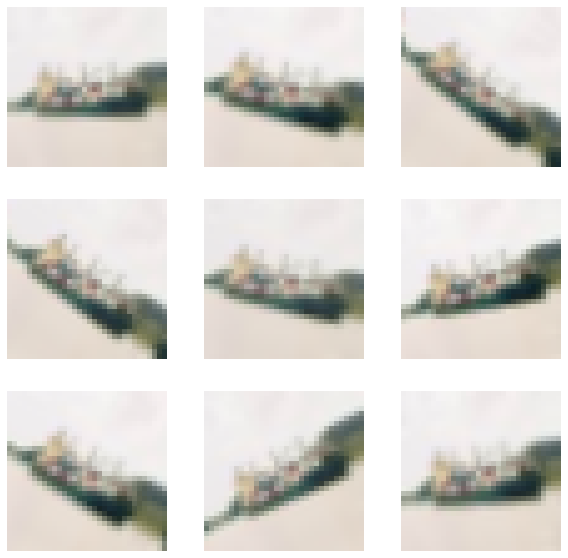

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy())
    plt.axis("off")

In [8]:
'''
Feature Extraction is performed by ResNet152 pretrained on imagenet weights. 
Input size is 224 x 224 since ResNet trained on 224x224 images.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.ResNet152(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Why GlobalPooling?
* To avoid horrific number of parameters
* If applied flatten, there would be 70M+ params.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalMaxPooling2D()(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(0.25),
                              kernel_regularizer = tf.keras.regularizers.l2(0.00007))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(0.25),
                              kernel_regularizer = tf.keras.regularizers.l2(0.00003))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
32 x 7 = 224, UpSampling.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    aug = data_augmentation(resize)

    resnet_feature_extractor = feature_extractor(aug)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
''' 


def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

234700800/234698864 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
____________________________________________________________

## Train the model

In [9]:
def scheduler(epoch, lr):
  if (epoch+1) % 3 == 0:
     return lr * tf.math.exp(-0.99)
  else:
     return lr

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                                      restore_best_weights=True)
lr_sch = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = np.sqrt(0.14),
                                              verbose = 1, patience = 2)

lr_man_sch = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
callbacks = [es, lr_sch,lr_man_sch]

EPOCHS = 64
history = model.fit(train_ds, epochs=EPOCHS, validation_data = val_ds, callbacks = callbacks)

Epoch 1/64

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
704/704 [==============================] - 583s 797ms/step - loss: 1.0715 - accuracy: 0.6723 - val_loss: 2.4844 - val_accuracy: 0.3342
Epoch 2/64

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0003000000142492354.
704/704 [==============================] - 558s 791ms/step - loss: 0.4484 - accuracy: 0.8729 - val_loss: 0.5566 - val_accuracy: 0.8398
Epoch 3/64

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.00011147301, shape=(), dtype=float32).
704/704 [==============================] - 558s 791ms/step - loss: 0.2869 - accuracy: 0.9254 - val_loss: 0.2313 - val_accuracy: 0.9416
Epoch 4/64

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001114730112021789.
704/704 [==============================] - 558s 791ms/step - loss: 0.1859 - accuracy: 0.9602 - val_loss: 0.2391 - val_accuracy: 0.9412
Epoch 5/64

Epoch 00005: LearningRateScheduler r

## Evaluate the Model

Calculate the loss and accuracy metric for the test set.

In [12]:
loss, accuracy = model.evaluate(test_ds)

157/157 [==============================] - 39s 244ms/step - loss: 0.1987 - accuracy: 0.9599


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

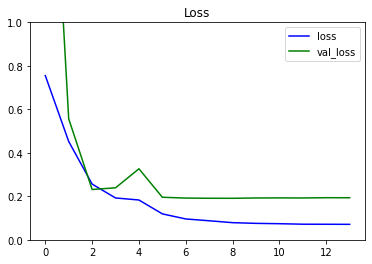

In [20]:
def plot_metrics(metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
  plt.legend()

plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

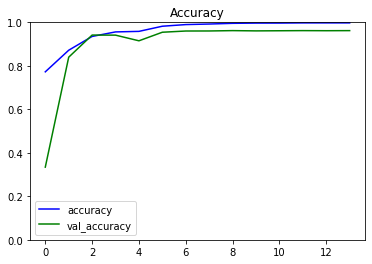

In [21]:
plot_metrics("accuracy", "Accuracy")